# Audio Classification

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '20'

In [2]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import IPython
from sklearn.model_selection import train_test_split
from keras.layers import Normalization

## Loading data

In [3]:
BASE_DIR = './temp/data/mini_speech_commands'
print([x for x in os.listdir(BASE_DIR) if x.lower() != 'readme.md'])
classes = ['go', 'yes', 'left']
NUM_CLASSES = len(classes)

FILES = []
for c in classes:
    dir_path = os.path.join(BASE_DIR, c)
    class_files = os.listdir(dir_path)
    class_files = [os.path.join(dir_path, x) for x in class_files]
    FILES.extend(class_files)

train_files, test_files = train_test_split(FILES, test_size=0.2)

['down', 'stop', 'left', 'go', 'right', 'up', 'no', 'yes']


Let's visualize some data

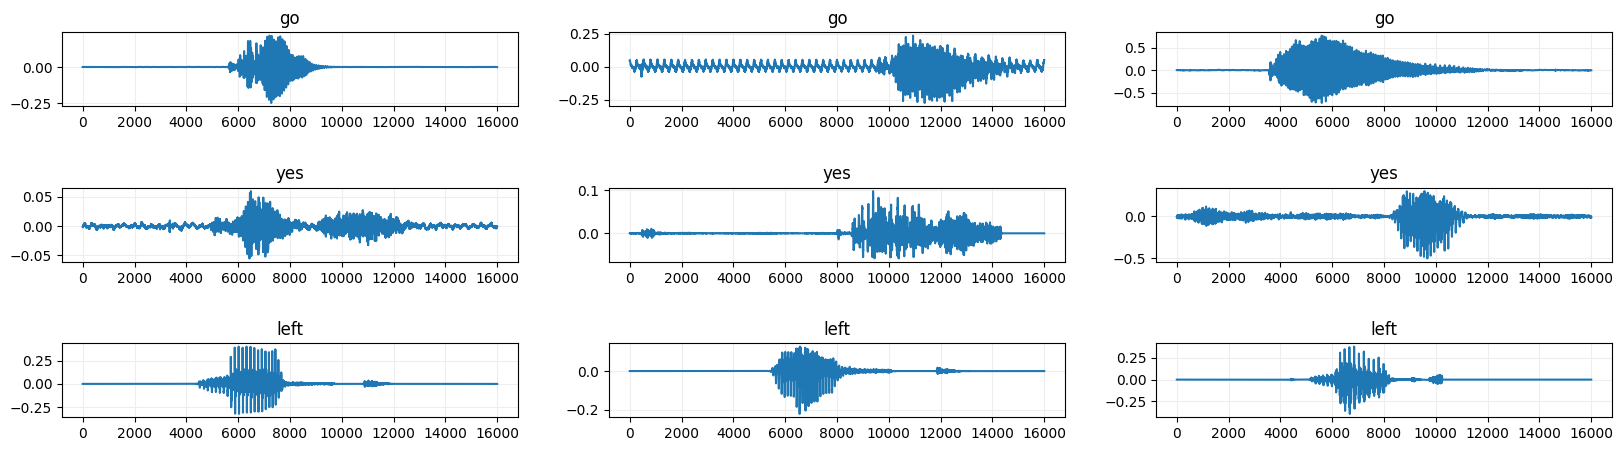

In [4]:
fig = plt.figure(figsize=(20, 5))
each_class = 3
cnt = 1
for c in classes:
    for i in range(each_class):
        dir_path = os.path.join(BASE_DIR, c)
        files = os.listdir(dir_path)
        file_name = random.choice(files)
        file_name = os.path.join(dir_path, file_name)
    
        file = tf.io.read_file(file_name)
        audio, rate = tf.audio.decode_wav(file, desired_samples=16000)
        audio = tf.squeeze(audio, axis=-1)
        ax = plt.subplot(NUM_CLASSES, each_class, cnt)
        ax.plot(audio)
        ax.grid(c='#eee')
        ax.set_title(c);
        cnt += 1

plt.subplots_adjust(hspace=1.1)

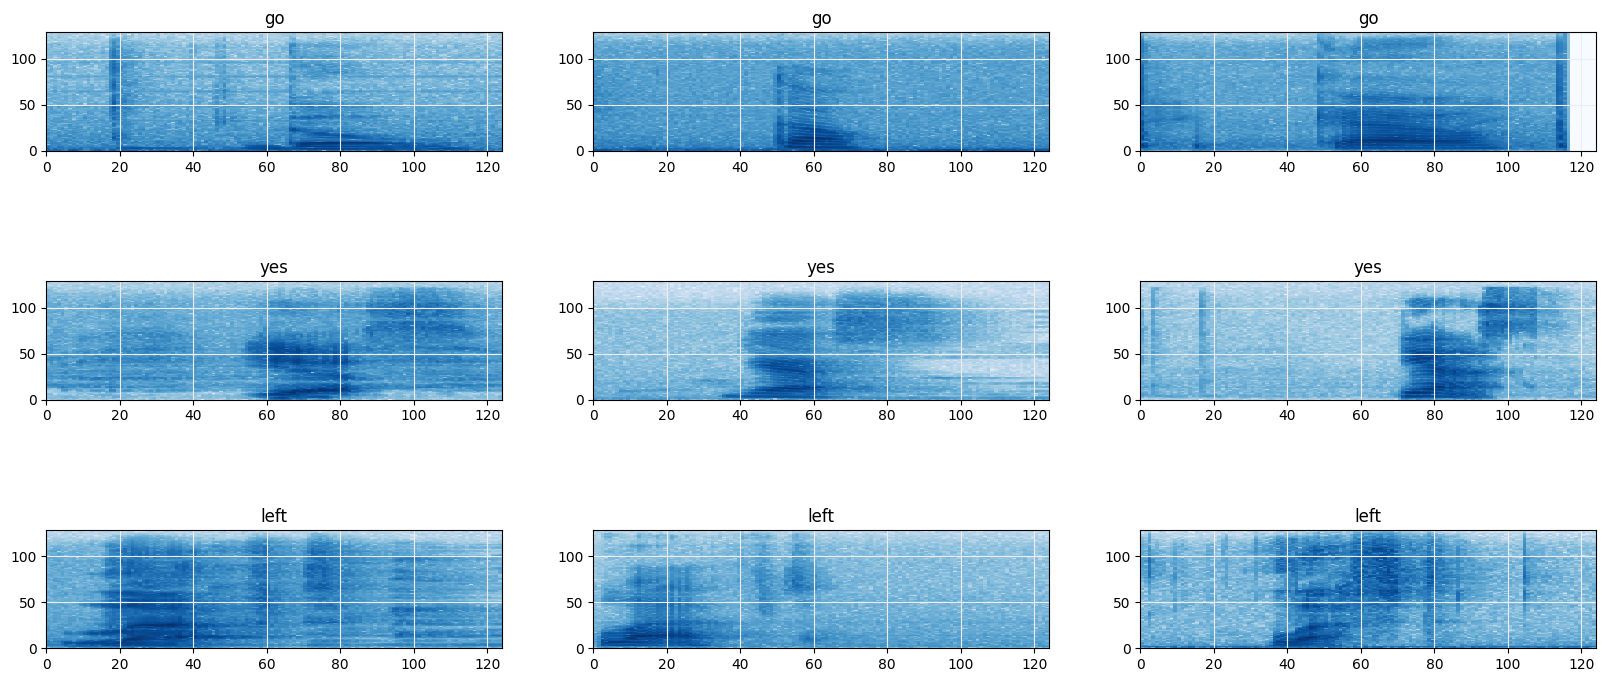

In [5]:
fig = plt.figure(figsize=(20, 8))
each_class = 3
cnt = 1
for c in classes:
    for i in range(each_class):
        dir_path = os.path.join(BASE_DIR, c)
        files = os.listdir(dir_path)
        file_name = random.choice(files)
        file_name = os.path.join(dir_path, file_name)
    
        file = tf.io.read_file(file_name)
        audio, rate = tf.audio.decode_wav(file, desired_samples=16000)
        audio = tf.squeeze(audio, axis=-1)
        spectrum = tf.abs(tf.signal.stft(audio, frame_length=255, frame_step=128))
        ax = plt.subplot(NUM_CLASSES, each_class, cnt)

        log_spec = np.log(spectrum.numpy().T + np.finfo(np.float32).eps)
        ax.pcolormesh(log_spec, cmap='Blues')
        ax.grid(c='#eee')
        ax.set_title(c);
        cnt += 1;

plt.subplots_adjust(hspace=1.1);

### Building a pipeline

In [6]:
SAMPLE_RATE = 16000
BATCH_SIZE = 64
AUTOTUNE = tf.data.experimental.AUTOTUNE
BUFFER = 1000
CLASSES = tf.convert_to_tensor(classes)

def read_wav_file(path):
    file = tf.io.read_file(path)
    audio, rate = tf.audio.decode_wav(file, desired_samples=SAMPLE_RATE)
    audio = tf.squeeze(audio, axis=-1)
    return audio


def get_spectrum(wav_file):
    spectrum = tf.abs(tf.signal.stft(wav_file, frame_length=255, frame_step=128))
    return spectrum


def get_label(path):
    label = tf.strings.split(path, sep=os.path.sep)[-2]
    label = tf.cast(CLASSES == label, dtype='float32')
    return label


def get_spectrum_and_labels(path):
    wav_file = read_wav_file(path)
    spectrum = get_spectrum(wav_file)
    label = get_label(path)
    return spectrum, label


train_ds = tf.data.Dataset.from_tensor_slices(train_files)
train_ds = train_ds.map(get_spectrum_and_labels, num_parallel_calls=AUTOTUNE)

normalizer = Normalization()
normalizer.adapt(train_ds.map(lambda s, l: s, num_parallel_calls=AUTOTUNE))

train_ds = train_ds.map(lambda s, l: (normalizer(s), l), num_parallel_calls=AUTOTUNE)
train_ds = train_ds.cache()
train_ds = train_ds.shuffle(BUFFER)
train_ds = train_ds.batch(BATCH_SIZE, num_parallel_calls=AUTOTUNE)
train_ds = train_ds.prefetch(AUTOTUNE)

valid_ds = tf.data.Dataset.from_tensor_slices(test_files)
valid_ds = valid_ds.map(get_spectrum_and_labels, num_parallel_calls=AUTOTUNE)
valid_ds = valid_ds.map(lambda s, l: (normalizer(s), l), num_parallel_calls=AUTOTUNE)
valid_ds = valid_ds.cache()
valid_ds = valid_ds.batch(BATCH_SIZE, num_parallel_calls=AUTOTUNE)
valid_ds = valid_ds.prefetch(AUTOTUNE)

In [7]:
for example_spectrum, example_label in train_ds.take(1):
    print('Spectrum shape:', example_spectrum.shape)
    print('Label shape:', example_label.shape)

Spectrum shape: (64, 124, 129)
Label shape: (64, 3)


## Building the model

In [8]:
from keras.layers import Layer, Conv1D, BatchNormalization, Dropout, Activation, Normalization, Input, MaxPool1D, Dense
from keras.layers import GlobalAveragePooling1D
from keras.models import Model
from keras.losses import CategoricalCrossentropy
from keras.metrics import F1Score, CategoricalAccuracy, Precision, Recall
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler

In [9]:
class ConvBlock(Layer):
    def __init__(self, filters, momentum=0.99):
        super(ConvBlock, self).__init__()

        self.conv = Conv1D(filters=filters, 
                           kernel_size=3, 
                           padding='same', 
                           name='conv')
        
        self.bn = BatchNormalization(momentum=momentum, 
                                     name='bn')
        
        self.act = Activation('relu', 
                              name='act')

    def call(self, input_tensor, training=False):
        x = self.conv(input_tensor)
        x = self.bn(x, training=training)
        x = self.act(x)
        return x

In [10]:
class ResBlock(Layer):
    def __init__(self, filters, momentum=0.99):
        super(ResBlock, self).__init__()

        self.conv_block1 = ConvBlock(filters[0],
                                     momentum=momentum)
        
        self.conv_block2 = ConvBlock(filters[1],
                                     momentum=momentum)
        
        self.conv_block3 = ConvBlock(filters=filters[2], 
                                     momentum=momentum)
        
        self.skip_connection = Conv1D(filters=filters[1], 
                                      kernel_size=1, 
                                      activation='linear', 
                                      name='skip_connection')
        
        self.maxpool = MaxPool1D(name='maxpool')
        

    def call(self, input_tensor, training=False):
        x = self.conv_block1(input_tensor)
        x = self.conv_block2(x)
        skipped = self.skip_connection(input_tensor)
        x = self.conv_block3(tf.add(x, skipped))
        x = self.maxpool(x)
        return x

In [11]:
class ResNet(Model):
    def __init__(self, num_classes, momentum=0.99):
        super(ResNet, self).__init__()

        self.base_conv = Conv1D(filters=64,
                                kernel_size=7, 
                                padding='same',
                                name='base_conv')

        self.bn = BatchNormalization(name='bn', 
                                     momentum=momentum)

        self.act = Activation('relu', name='act')

        self.maxpool = MaxPool1D(name='maxpool')

        self.res_block1 = ResBlock(filters=[64, 64, 128], momentum=momentum)
        self.res_block2 = ResBlock(filters=[128, 128, 256], momentum=momentum)
        self.res_block3 = ResBlock(filters=[256, 256, 512], momentum=momentum)

        self.global_avg = GlobalAveragePooling1D(name='global_avg')

        self.dropout = Dropout(0.7, name='dropout')
        self.classifier = Dense(num_classes, activation='softmax')


    def build(self, input_shape):
        inputs = Input(shape=input_shape)
        self.call(inputs)
        self.built = True


    def call(self, input_tensor, training=False):
        x = self.base_conv(input_tensor)
        x = self.bn(x, training=training)
        x = self.act(x)
        x = self.maxpool(x)

        x = self.res_block1(x, training=training)
        x = self.res_block2(x, training=training)
        x = self.res_block3(x, training=training)

        x = self.global_avg(x)
        x = self.dropout(x, training=training)
        x = self.classifier(x)
        return x

In [12]:
resnet = ResNet(NUM_CLASSES)
resnet.build(input_shape=(example_spectrum.shape[1:]))
resnet.summary()

metrics = [
    CategoricalAccuracy('accuracy'),
    Precision(name='precision'),
    Recall(name='recall'),
    F1Score(name='f1-score')
]

resnet.compile(
    loss=CategoricalCrossentropy(),
    optimizer=Adam(),
    metrics=metrics
)

Model: "res_net"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 base_conv (Conv1D)          (None, 124, 64)           57856     
                                                                 
 bn (BatchNormalization)     (None, 124, 64)           256       
                                                                 
 act (Activation)            (None, 124, 64)           0         
                                                                 
 maxpool (MaxPooling1D)      (None, 62, 64)            0         
                                                                 
 res_block (ResBlock)        (None, 31, 128)           54592     
                                                                 
 res_block_1 (ResBlock)      (None, 15, 256)           215680    
                                                                 
 res_block_2 (ResBlock)      (None, 7, 512)            8573

In [13]:
def get_scheduler(initial_learning_rate, weight=0.98, min_learning_rate=1e-5):
    def func(epoch):
        return max(min_learning_rate, initial_learning_rate * weight ** epoch)
    return func


scheduler = get_scheduler(3e-3, weight=0.95)
lr_scheduler = LearningRateScheduler(scheduler)
callbacks = [lr_scheduler]

In [14]:
history = resnet.fit(train_ds,
                     epochs=200, 
                     validation_data=valid_ds, 
                     callbacks=callbacks)

Epoch 1/200


I0000 00:00:1715117727.479493  737579 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


38/38 [==============================] - 14s 67ms/step - loss: 0.8108 - accuracy: 0.6587 - precision: 0.7153 - recall: 0.5758 - f1-score: 0.6577 - val_loss: 12.4675 - val_accuracy: 0.4133 - val_precision: 0.4133 - val_recall: 0.4133 - val_f1-score: 0.3089 - lr: 0.0030
Epoch 2/200
38/38 [==============================] - 1s 14ms/step - loss: 0.3391 - accuracy: 0.8783 - precision: 0.8986 - recall: 0.8600 - f1-score: 0.8783 - val_loss: 1.1188 - val_accuracy: 0.8533 - val_precision: 0.8555 - val_recall: 0.8483 - val_f1-score: 0.8540 - lr: 0.0029
Epoch 3/200
38/38 [==============================] - 1s 14ms/step - loss: 0.2767 - accuracy: 0.9079 - precision: 0.9298 - recall: 0.8888 - f1-score: 0.9078 - val_loss: 0.5930 - val_accuracy: 0.8750 - val_precision: 0.8763 - val_recall: 0.8733 - val_f1-score: 0.8779 - lr: 0.0027
Epoch 4/200
38/38 [==============================] - 1s 14ms/step - loss: 0.2349 - accuracy: 0.9200 - precision: 0.9398 - recall: 0.9042 - f1-score: 0.9199 - val_loss: 0.530

## Evaluation

In [15]:
from sklearn.metrics import classification_report

def plot(history, key, ax):
    val_key = 'val_' + key
    ax.plot(history.epoch, history.history[key], label=key)
    ax.plot(history.epoch, history.history[val_key], label=val_key)
    ax.grid(c='#eee')
    ax.set_title(f'{key.capitalize()} per epoch')
    ax.set_xlabel('epoch')
    ax.set_ylabel(f'{key}')
    plt.legend();

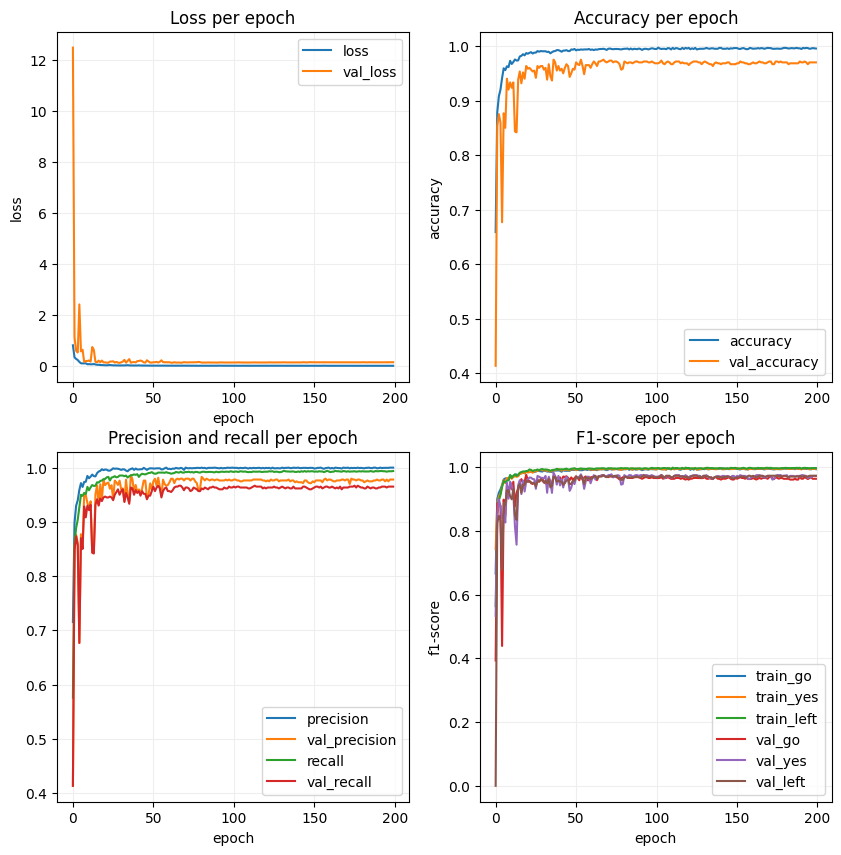

In [16]:
fig = plt.figure(figsize=(10, 10))

ax = plt.subplot(2, 2, 1)
plot(history, 'loss', ax);

ax = plt.subplot(2, 2, 2)
plot(history, 'accuracy', ax);

ax = plt.subplot(2, 2, 3)
plot(history, 'precision', ax);
plot(history, 'recall', ax);
ax.set_title('Precision and recall per epoch');
ax.set_ylabel('');

ax = plt.subplot(2, 2, 4)
plot(history, 'f1-score', ax);
ax.legend(labels=['train_' + c for c in classes] + ['val_' + c for c in classes]);

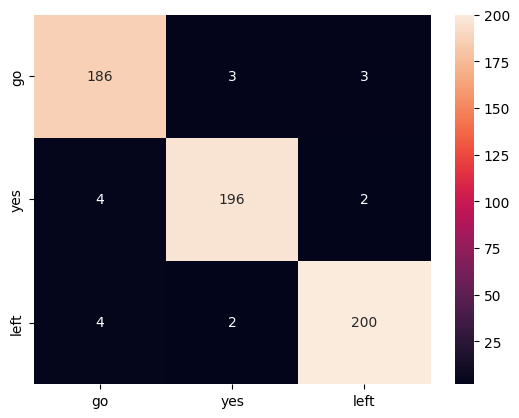

In [17]:
pred = resnet.predict(valid_ds, verbose=0)
pred = tf.argmax(pred, axis=-1)

y_true = tf.concat([tf.argmax(l, axis=-1) for s, l in valid_ds], axis=-1)

conf_matrix = tf.math.confusion_matrix(y_true, pred)
sns.heatmap(conf_matrix, annot=True, xticklabels=classes, yticklabels=classes, fmt='g');

In [18]:
print(classification_report(y_true, pred, target_names=classes))

              precision    recall  f1-score   support

          go       0.96      0.97      0.96       192
         yes       0.98      0.97      0.97       202
        left       0.98      0.97      0.97       206

    accuracy                           0.97       600
   macro avg       0.97      0.97      0.97       600
weighted avg       0.97      0.97      0.97       600



## Save the model

In [19]:
class ExportModel(tf.Module):
    def __init__(self, model):
        super(ExportModel, self).__init__()

        self.model = model
    
    @tf.function(input_signature=[tf.TensorSpec(shape=(None, 16000), dtype=tf.float32)])
    def __call__(self, x):
        spectrum = tf.abs(tf.signal.stft(x, frame_length=255, frame_step=128))
        spectrum = normalizer(spectrum)
        pred = self.model(spectrum, training=False)
        y_hat = tf.argmax(pred, axis=-1)
        class_names = tf.gather(classes, y_hat)
        return {
            'predictions':pred,
            'class':class_names,
            'class_id':y_hat
        }

In [20]:
# Let's do a prediction
export_model = ExportModel(resnet)
wav_file = read_wav_file('./temp/data/mini_speech_commands/left/063d48cf_nohash_0.wav')
export_model(wav_file[None, :])

{'predictions': <tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[2.25319785e-09, 1.47430015e-08, 1.00000000e+00]], dtype=float32)>,
 'class': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'left'], dtype=object)>,
 'class_id': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([2])>}

In [21]:
tf.saved_model.save(export_model, './temp/exported_model.tf')

INFO:tensorflow:Assets written to: ./temp/exported_model.tf/assets


INFO:tensorflow:Assets written to: ./temp/exported_model.tf/assets


#### Creating a tflite file for edge devices

In [22]:
converter = tf.lite.TFLiteConverter.from_saved_model('./temp/exported_model.tf/')
tflite_export = converter.convert()

with open('./temp/tflite_exported_model.tflite', 'wb') as file:
    file.write(tflite_export)

Summary on the non-converted ops:
---------------------------------
 * Accepted dialects: tfl, builtin, func
 * Non-Converted Ops: 72, Total Ops 195, % non-converted = 36.92 %
 * 72 ARITH ops

- arith.constant:   72 occurrences  (: 1, f32: 55, i32: 16)



  (f32: 26, i32: 2)
  (i64: 1)
  (f32: 1)
  (i32: 3)
  (f32: 13)
  (f32: 15)
  (i32: 2)
  (f32: 1)
  (: 1, f32: 1)
  (f32: 4)
  (i32: 1)
  (f32: 1)
  (f32: 12, i32: 1)
  (i32: 3)
  (f32: 1)
  (i32: 1)
  (f32: 2, i32: 3)
  (: 1)
  (i32: 1)
  (f32: 1)
  (i32: 1)
  (: 1, f32: 17)
  (f32: 1)
  (f32: 1, i32: 1)
